# Классификатор отзывов

Импорт библиотек

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm import tqdm
import time
import os

In [2]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"  # Отключает TensorFlow
os.environ["TRANSFORMERS_NO_JAX"] = "1"  # Отключает JAX (опционально)

In [20]:
# Проверяем доступность GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to C:\Users\Delta-
[nltk_data]     Game\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Delta-
[nltk_data]     Game\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Delta-
[nltk_data]     Game\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Импорт датасета

In [4]:
df = pd.read_csv('C:/Users/Delta-Game/Desktop/Jupyter_projects/MentorEx/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
# Баланс классов
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [6]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [7]:
# Дубликаты и шум
print("\nDuplicates:", df.duplicated().sum())
print("Missing values:", df.isnull().sum())
# Проверка HTML-тегов
html_samples = df['review'].str.contains('<br />').sum()
print("Reviews with <br /> tags:", html_samples)


Duplicates: 418
Missing values: review       0
sentiment    0
dtype: int64
Reviews with <br /> tags: 29200


In [8]:
# Длина отзывов
df['length_words'] = df['review'].apply(lambda x: len(word_tokenize(x)))
df['length_chars'] = df['review'].apply(len)
print("\nСтатистика длины отзывов (слова):")
print(df.groupby('sentiment')['length_words'].describe())
print("\nСтатистика длины отзывов (символы):")
print(df.groupby('sentiment')['length_chars'].describe())


Статистика длины отзывов (слова):
             count       mean         std   min    25%    50%    75%     max
sentiment                                                                   
negative   25000.0  278.60944  201.294667   8.0  153.0  211.0  338.0  1936.0
positive   25000.0  280.35800  214.399014  11.0  148.0  207.0  343.0  2911.0

Статистика длины отзывов (символы):
             count        mean          std   min    25%    50%      75%  \
sentiment                                                                  
negative   25000.0  1294.06436   945.892669  32.0  706.0  973.0  1567.25   
positive   25000.0  1324.79768  1031.492627  65.0  691.0  968.0  1614.00   

               max  
sentiment           
negative    8969.0  
positive   13704.0  


In [9]:
# Топ-10 слов по классам
stop_words = set(stopwords.words('english'))
def clean_text(text):
    text = re.sub(r'<br />', ' ', text.lower())
    text = re.sub(r'[^a-z ]', '', text)
    tokens = word_tokenize(text)
    return [w for w in tokens if w not in stop_words]

# для positive
positive_reviews = df[df['sentiment'] == 'positive']['review']
positive_words = [word for review in positive_reviews for word in clean_text(review)]
positive_top = Counter(positive_words).most_common(10)
print("\nTop 10 words for positive reviews:", positive_top)

# для negative
negative_reviews = df[df['sentiment'] == 'negative']['review']
negative_words = [word for review in negative_reviews for word in clean_text(review)]
negative_top = Counter(negative_words).most_common(10)
print("Top 10 words for negative reviews:", negative_top)


Top 10 words for positive reviews: [('film', 40166), ('movie', 36709), ('one', 26294), ('like', 17180), ('good', 14573), ('great', 12812), ('story', 12612), ('time', 12129), ('see', 11985), ('well', 11406)]
Top 10 words for negative reviews: [('movie', 48525), ('film', 35867), ('one', 25185), ('like', 21883), ('even', 15098), ('bad', 14374), ('good', 14340), ('would', 13653), ('really', 12293), ('time', 11841)]


In [10]:
# Категориальные данные
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
df.head()

,review,sentiment,length_words,length_chars
0,One of the other reviewers has mentioned that ...,1,380,1761
1,A wonderful little production. <br /><br />The...,1,201,998
2,I thought this was a wonderful way to spend ti...,1,205,926
3,Basically there's a family where a little boy ...,0,175,748
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,283,1317


In [11]:
# Разделение на тренировочную и тестовую выборки
df['cleaned_review'] = df['review'].apply(clean_text)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['cleaned_review'].tolist(), 
    df['sentiment'].tolist(), 
    test_size=0.2, 
    random_state=42,
    stratify=df['sentiment']
)
df.head()

,review,sentiment,length_words,length_chars,cleaned_review
0,One of the other reviewers has mentioned that ...,1,380,1761,"[one, reviewers, mentioned, watching, oz, epis..."
1,A wonderful little production. <br /><br />The...,1,201,998,"[wonderful, little, production, filming, techn..."
2,I thought this was a wonderful way to spend ti...,1,205,926,"[thought, wonderful, way, spend, time, hot, su..."
3,Basically there's a family where a little boy ...,0,175,748,"[basically, theres, family, little, boy, jake,..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,283,1317,"[petter, matteis, love, time, money, visually,..."


# BERT

In [21]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Токенизация данных
def tokenize_data(texts, labels, max_length=512):
    input_ids = []
    attention_masks = []
    
    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,                      # Текст для токенизации
            add_special_tokens=True,   # Добавляем [CLS] и [SEP]
            max_length=max_length,     # Максимальная длина последовательности
            padding='max_length',      # Дополняем до max_length
            truncation=True,           # Обрезаем если longer than max_length
            return_attention_mask=True, # Возвращаем маску внимания
            return_tensors='pt',       # Возвращаем тензоры PyTorch
        )
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    
    return input_ids, attention_masks, labels

# Токенизируем тренировочные и тестовые данные
print("Tokenizing training data...")
train_input_ids, train_attention_masks, train_labels = tokenize_data(train_texts, train_labels)

print("Tokenizing test data...")
test_input_ids, test_attention_masks, test_labels = tokenize_data(test_texts, test_labels)



Tokenizing training data...


C:\Users\Delta-Game\AppData\Local\Temp\ipykernel_12856\1390920367.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


Tokenizing test data...


In [22]:
# Создаем DataLoader
batch_size = 16

train_data = TensorDataset(train_input_ids, train_attention_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [24]:
# Перемещаем модель на устройство
model.to(device)
print(f"Model device: {next(model.parameters()).device}")

# Используем стандартный оптимизатор PyTorch
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5, weight_decay=0.01)

# Функция для расчета точности
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


Model device: cuda:0


In [25]:
# Обучение модели
training_stats = []
total_t0 = time.time()
epochs = 3

for epoch_i in range(0, epochs):
    print(f'======== Epoch {epoch_i + 1} / {epochs} ========')
    print('Training...')
    
    total_train_loss = 0
    model.train()
    
    for step, batch in enumerate(tqdm(train_dataloader, desc="Training")):
        # Перемещаем данные на устройство
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Проверяем, что все данные на правильном устройстве
        if step == 0:
            print(f"Batch data device - input_ids: {b_input_ids.device}")
            print(f"Batch data device - attention_mask: {b_input_mask.device}")
            print(f"Batch data device - labels: {b_labels.device}")
            print(f"Model device: {next(model.parameters()).device}")
        
        model.zero_grad()
        
        outputs = model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask,
            labels=b_labels
        )
        
        loss = outputs.loss
        total_train_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
    
    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f"Average training loss: {avg_train_loss:.2f}")
    
    # Валидация
    print("Running Validation...")
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    
    for batch in tqdm(test_dataloader, desc="Evaluating"):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():
            outputs = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask,
                labels=b_labels
            )
        
        loss = outputs.loss
        logits = outputs.logits
        
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)
    
    avg_val_accuracy = total_eval_accuracy / len(test_dataloader)
    print(f"Accuracy: {avg_val_accuracy:.2f}")
    
    avg_val_loss = total_eval_loss / len(test_dataloader)
    
    training_stats.append({
        'epoch': epoch_i + 1,
        'Training Loss': avg_train_loss,
        'Valid. Loss': avg_val_loss,
        'Valid. Accur.': avg_val_accuracy
    })

print("Training complete!")
print(f"Total training took {(time.time() - total_t0) / 60:.2f} minutes")


======== Epoch 1 / 3 ========
Training...


Training:   0%|                                                                               | 0/2500 [00:00<?, ?it/s]

Batch data device - input_ids: cuda:0
Batch data device - attention_mask: cuda:0
Batch data device - labels: cuda:0
Model device: cuda:0


Training: 100%|████████████████████████████████████████████████████████████████████| 2500/2500 [28:48<00:00,  1.45it/s]


Average training loss: 0.42
Running Validation...


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 625/625 [01:58<00:00,  5.25it/s]


Accuracy: 0.85
======== Epoch 2 / 3 ========
Training...


Training:   0%|                                                                               | 0/2500 [00:00<?, ?it/s]

Batch data device - input_ids: cuda:0
Batch data device - attention_mask: cuda:0
Batch data device - labels: cuda:0
Model device: cuda:0


Training: 100%|████████████████████████████████████████████████████████████████████| 2500/2500 [28:24<00:00,  1.47it/s]


Average training loss: 0.42
Running Validation...


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 625/625 [01:59<00:00,  5.23it/s]


Accuracy: 0.82
======== Epoch 3 / 3 ========
Training...


Training:   0%|                                                                               | 0/2500 [00:00<?, ?it/s]

Batch data device - input_ids: cuda:0
Batch data device - attention_mask: cuda:0
Batch data device - labels: cuda:0
Model device: cuda:0


Training: 100%|████████████████████████████████████████████████████████████████████| 2500/2500 [29:15<00:00,  1.42it/s]


Average training loss: 0.43
Running Validation...


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 625/625 [02:00<00:00,  5.18it/s]

Accuracy: 0.85
Training complete!
Total training took 92.46 minutes


In [26]:
# Сохранение модели
output_dir = './model_save/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print(f"Saving model to {output_dir}")
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Загрузка модели для предсказаний
print("Loading model for predictions...")
model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)
model.to(device)

# Функция для предсказания на новых данных
def predict_sentiment(text):
    model.eval()
    
    # Очистка текста
    text = re.sub(r'<br />', ' ', text.lower())
    text = re.sub(r'[^a-z ]', '', text)
    
    encoded_dict = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    
    input_id = encoded_dict['input_ids'].to(device)
    attention_mask = encoded_dict['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_id, token_type_ids=None, attention_mask=attention_mask)
    
    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    prediction = np.argmax(logits, axis=1).flatten()
    
    return "Positive" if prediction[0] == 1 else "Negative"


Saving model to ./model_save/
Loading model for predictions...


In [27]:
# Пример предсказания
print("\nTesting model predictions:")
sample_texts = [
    "This movie was fantastic! I really enjoyed it.",
    "This was the worst movie I've ever seen. Terrible acting and plot.",
    "The film had some good moments but overall was disappointing.",
    "An absolute masterpiece with brilliant performances."
]

for text in sample_texts:
    sentiment = predict_sentiment(text)
    print(f"'{text}' -> {sentiment}")


Testing model predictions:
'This movie was fantastic! I really enjoyed it.' -> Positive
'This was the worst movie I've ever seen. Terrible acting and plot.' -> Negative
'The film had some good moments but overall was disappointing.' -> Negative
'An absolute masterpiece with brilliant performances.' -> Positive


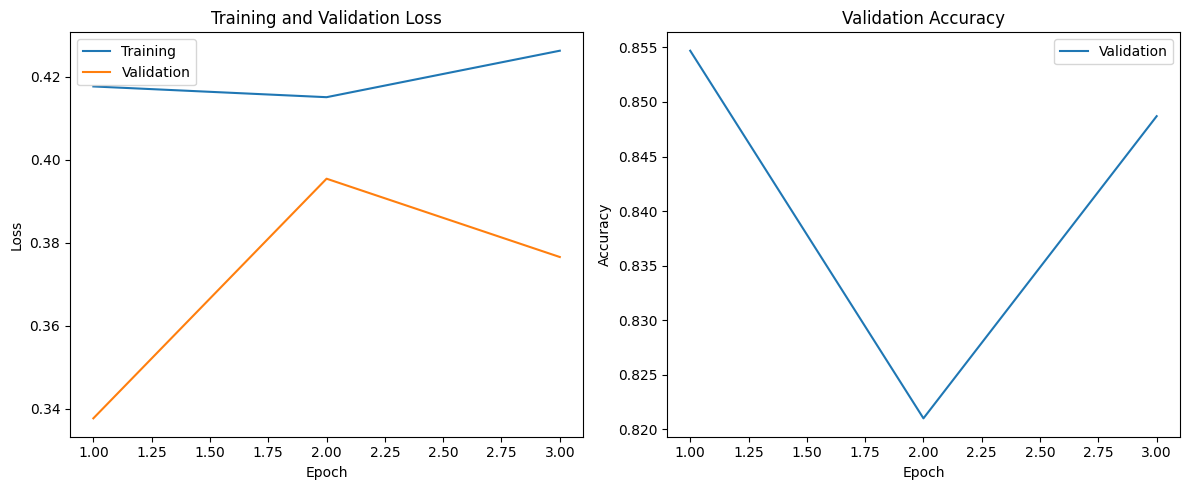

In [28]:
# Визуализация результатов обучения
plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot([x['epoch'] for x in training_stats], [x['Training Loss'] for x in training_stats], label='Training')
plt.plot([x['epoch'] for x in training_stats], [x['Valid. Loss'] for x in training_stats], label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot([x['epoch'] for x in training_stats], [x['Valid. Accur.'] for x in training_stats], label='Validation')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('./training_results.png')
plt.show()


Анализ кривых:  
- Кривая train стабильна (около 0,42) - модель достигла плато слишком рано, возможно недообучение (слишком низкий learning rate?)
- Кривая Validation нестабильна, что вроде бв нормально
- Точно не переобучение, так как ошибка на train больше чем на validation
- Теперь Validation Accurancy:
    - Тоже нормально что нестабильна

Вопросы:
Как это анализировать?

In [29]:
# Детальная оценка на тестовом наборе
print("\nDetailed evaluation on test set:")
model.eval()
predictions = []
true_labels = []

for batch in test_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    
    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    predictions.extend(np.argmax(logits, axis=1).flatten())
    true_labels.extend(label_ids.flatten())

print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=['Negative', 'Positive']))

print(f"Final Accuracy: {accuracy_score(true_labels, predictions):.4f}")


Detailed evaluation on test set:
Classification Report:
              precision    recall  f1-score   support

    Negative       0.86      0.83      0.85      5000
    Positive       0.84      0.87      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

Final Accuracy: 0.8487


Анализ результатов:
- precision: резница между FN и TP небольшая (0,02) - модель сбалансирована
- recall: разница между FN и TP небольшая (0,03) - модель сбалансирована
- f1 = 0.85 у обоих классов - нет смещения, это хорошо
-  финальная точность - 0,85, что значит что модель правильно угадывает 85% отзывов - норм результат, но можно лучше

# RNN (LSTM и GRU)

In [43]:
# Предобработка для RNN (LSTM/GRU)
# Построить vocabulary из train_texts (списки слов)
all_train_words = [word for text in train_texts for word in text]
word_counts = Counter(all_train_words)
vocab_size = 20000  # Ограничиваем топ-20000 слов
vocab = {word: idx + 2 for idx, (word, _) in enumerate(word_counts.most_common(vocab_size))}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1
print(f"Vocabulary size: {len(vocab)}")

Vocabulary size: 20002


In [44]:
# Функция для конвертации текста в последовательность индексов
def text_to_sequence(text, vocab, max_length=256):
    seq = [vocab.get(word, vocab['<UNK>']) for word in text]
    if len(seq) > max_length:
        seq = seq[:max_length]  # Truncation
    return seq

# Конвертировать train и test в последовательности
max_length = 256  # На основе df['length_words'].quantile(0.95) ~250-300
train_sequences = [torch.tensor(text_to_sequence(text, vocab, max_length)) for text in train_texts]
test_sequences = [torch.tensor(text_to_sequence(text, vocab, max_length)) for text in test_texts]

# Длины последовательностей (для pack_padded_sequence)
train_lengths = [min(len(seq), max_length) for seq in train_sequences]
test_lengths = [min(len(seq), max_length) for seq in test_sequences]

# Padding
train_padded = nn.utils.rnn.pad_sequence(train_sequences, batch_first=True, padding_value=0)
test_padded = nn.utils.rnn.pad_sequence(test_sequences, batch_first=True, padding_value=0)

# Создать тензоры labels
train_labels_tensor = torch.tensor(train_labels)
test_labels_tensor = torch.tensor(test_labels)

C:\Users\Delta-Game\AppData\Local\Temp\ipykernel_12856\345277192.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(train_labels)
C:\Users\Delta-Game\AppData\Local\Temp\ipykernel_12856\345277192.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels_tensor = torch.tensor(test_labels)


In [45]:
# DataLoaders для RNN (с lengths)
batch_size_rnn = 64
train_data_rnn = TensorDataset(train_padded, torch.tensor(train_lengths), train_labels_tensor)
test_data_rnn = TensorDataset(test_padded, torch.tensor(test_lengths), test_labels_tensor)

train_dataloader_rnn = DataLoader(train_data_rnn, sampler=RandomSampler(train_data_rnn), batch_size=batch_size_rnn)
test_dataloader_rnn = DataLoader(test_data_rnn, sampler=SequentialSampler(test_data_rnn), batch_size=batch_size_rnn)

In [50]:
# Определение модели RNN
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout, rnn_type='LSTM'):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn_type = rnn_type
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True, bidirectional=True)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, 2)  # Для bidirectional
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, lengths):
        embeds = self.embedding(x)
        
        # Pack (требует sorted по lengths descending)
        packed_embeds = nn.utils.rnn.pack_padded_sequence(embeds, lengths.cpu(), batch_first=True, enforce_sorted=True)
        
        if self.rnn_type == 'LSTM':
            packed_out, (h_n, c_n) = self.rnn(packed_embeds)
        else:  # GRU
            packed_out, h_n = self.rnn(packed_embeds)
        
        # h_n: (num_layers * 2, batch, hidden) для bidirectional
        # Concat last layer forward + backward
        h_n = torch.cat((h_n[-2, :, :], h_n[-1, :, :]), dim=1)  # (batch, hidden*2)
        
        out = self.dropout(h_n)
        return self.fc(out)

# Гиперпараметры
embedding_dim = 300
hidden_dim = 128
num_layers = 2
dropout = 0.3
lr = 0.0005
epochs_rnn = 10

In [51]:
# Функция для обучения
def train_rnn(model, train_dataloader, test_dataloader, epochs, lr, device):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)
    criterion = nn.CrossEntropyLoss()
    
    training_stats = []
    for epoch in range(epochs):
        print(f'======== Epoch {epoch + 1} / {epochs} ========')
        model.train()
        total_train_loss = 0
        for batch in tqdm(train_dataloader, desc="Training"):
            inputs, lengths, labels = batch[0].to(device), batch[1].to(device), batch[2].to(device)
            
            # Sort by lengths descending
            sorted_idx = torch.argsort(lengths, descending=True)
            inputs = inputs[sorted_idx]
            lengths = lengths[sorted_idx]
            labels = labels[sorted_idx]
            
            optimizer.zero_grad()
            outputs = model(inputs, lengths)
            loss = criterion(outputs, labels)
            total_train_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        
        avg_train_loss = total_train_loss / len(train_dataloader)
        
        # Validation
        model.eval()
        total_eval_loss = 0
        total_eval_acc = 0
        for batch in tqdm(test_dataloader, desc="Evaluating"):
            inputs, lengths, labels = batch[0].to(device), batch[1].to(device), batch[2].to(device)
            
            sorted_idx = torch.argsort(lengths, descending=True)
            inputs = inputs[sorted_idx]
            lengths = lengths[sorted_idx]
            labels = labels[sorted_idx]
            
            with torch.no_grad():
                outputs = model(inputs, lengths)
            loss = criterion(outputs, labels)
            total_eval_loss += loss.item()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            total_eval_acc += np.mean(preds == labels.cpu().numpy())
        
        avg_val_loss = total_eval_loss / len(test_dataloader)
        avg_val_acc = total_eval_acc / len(test_dataloader)
        
        training_stats.append({
            'epoch': epoch + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_acc
        })
        print(f"Avg Train Loss: {avg_train_loss:.2f}, Val Loss: {avg_val_loss:.2f}, Val Acc: {avg_val_acc:.2f}")
    
    return training_stats

In [52]:
# Функция для визуализации
def plot_stats(stats, title):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot([x['epoch'] for x in stats], [x['Training Loss'] for x in stats], label='Train Loss')
    plt.plot([x['epoch'] for x in stats], [x['Valid. Loss'] for x in stats], label='Val Loss')
    plt.title(f'{title} Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot([x['epoch'] for x in stats], [x['Valid. Accur.'] for x in stats], label='Val Acc')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'./{title.lower()}_results.png')
    plt.show()

# Функция для оценки
def evaluate_model(model, dataloader, device):
    model.eval()
    predictions, true_labels = [], []
    for batch in dataloader:
        inputs, lengths, labels = batch[0].to(device), batch[1].to(device), batch[2].to(device)
        
        sorted_idx = torch.argsort(lengths, descending=True)
        inputs = inputs[sorted_idx]
        lengths = lengths[sorted_idx]
        labels = labels[sorted_idx]
        
        with torch.no_grad():
            outputs = model(inputs, lengths)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(labels.cpu().numpy())
    print(classification_report(true_labels, predictions, target_names=['Negative', 'Positive']))
    print(f"Accuracy: {accuracy_score(true_labels, predictions):.4f}")

In [53]:
# Обучение LSTM
print("Training LSTM...")
lstm_model = RNNModel(len(vocab), embedding_dim, hidden_dim, num_layers, dropout, 'LSTM')
lstm_stats = train_rnn(lstm_model, train_dataloader_rnn, test_dataloader_rnn, epochs_rnn, lr, device)

Training LSTM...
======== Epoch 1 / 10 ========


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 38.94it/s]


Avg Train Loss: 0.63, Val Loss: 0.54, Val Acc: 0.74
======== Epoch 2 / 10 ========


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 157/157 [00:03<00:00, 39.64it/s]


Avg Train Loss: 0.54, Val Loss: 0.52, Val Acc: 0.75
======== Epoch 3 / 10 ========


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 38.16it/s]


Avg Train Loss: 0.53, Val Loss: 0.60, Val Acc: 0.72
======== Epoch 4 / 10 ========


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 157/157 [00:03<00:00, 40.06it/s]


Avg Train Loss: 0.53, Val Loss: 0.51, Val Acc: 0.75
======== Epoch 5 / 10 ========


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 157/157 [00:03<00:00, 39.55it/s]


Avg Train Loss: 0.52, Val Loss: 0.54, Val Acc: 0.74
======== Epoch 6 / 10 ========


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 157/157 [00:03<00:00, 40.10it/s]


Avg Train Loss: 0.53, Val Loss: 0.53, Val Acc: 0.75
======== Epoch 7 / 10 ========


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 157/157 [00:03<00:00, 39.88it/s]


Avg Train Loss: 0.52, Val Loss: 0.51, Val Acc: 0.76
======== Epoch 8 / 10 ========


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 157/157 [00:03<00:00, 39.99it/s]


Avg Train Loss: 0.51, Val Loss: 0.52, Val Acc: 0.75
======== Epoch 9 / 10 ========


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 157/157 [00:03<00:00, 39.34it/s]


Avg Train Loss: 0.50, Val Loss: 0.52, Val Acc: 0.76
======== Epoch 10 / 10 ========


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 157/157 [00:03<00:00, 39.60it/s]

Avg Train Loss: 0.49, Val Loss: 0.50, Val Acc: 0.77


In [54]:
# Обучение GRU
print("Training GRU...")
gru_model = RNNModel(len(vocab), embedding_dim, hidden_dim, num_layers, dropout, 'GRU')
gru_stats = train_rnn(gru_model, train_dataloader_rnn, test_dataloader_rnn, epochs_rnn, lr, device)


Training GRU...
======== Epoch 1 / 10 ========


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 157/157 [00:03<00:00, 39.64it/s]


Avg Train Loss: 0.58, Val Loss: 0.51, Val Acc: 0.76
======== Epoch 2 / 10 ========


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 39.14it/s]


Avg Train Loss: 0.51, Val Loss: 0.51, Val Acc: 0.76
======== Epoch 3 / 10 ========


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 157/157 [00:03<00:00, 39.39it/s]


Avg Train Loss: 0.50, Val Loss: 0.48, Val Acc: 0.78
======== Epoch 4 / 10 ========


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 157/157 [00:03<00:00, 39.44it/s]


Avg Train Loss: 0.50, Val Loss: 0.49, Val Acc: 0.76
======== Epoch 5 / 10 ========


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 38.27it/s]


Avg Train Loss: 0.51, Val Loss: 0.51, Val Acc: 0.76
======== Epoch 6 / 10 ========


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 157/157 [00:03<00:00, 39.90it/s]


Avg Train Loss: 0.51, Val Loss: 0.49, Val Acc: 0.77
======== Epoch 7 / 10 ========


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 39.05it/s]


Avg Train Loss: 0.50, Val Loss: 0.49, Val Acc: 0.77
======== Epoch 8 / 10 ========


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 38.65it/s]


Avg Train Loss: 0.49, Val Loss: 0.49, Val Acc: 0.77
======== Epoch 9 / 10 ========


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 38.89it/s]


Avg Train Loss: 0.48, Val Loss: 0.44, Val Acc: 0.81
======== Epoch 10 / 10 ========


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 38.54it/s]

Avg Train Loss: 0.46, Val Loss: 0.44, Val Acc: 0.81


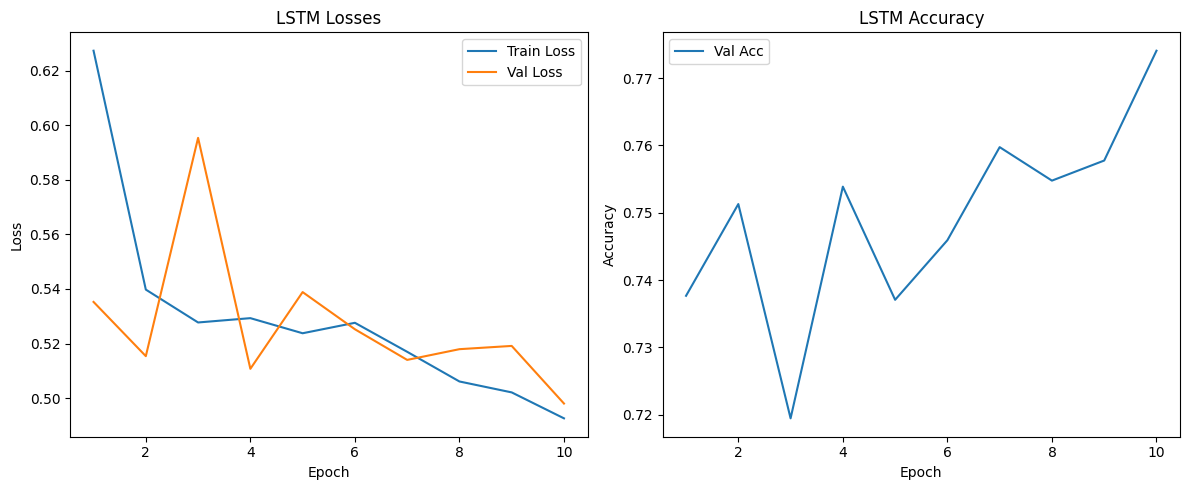

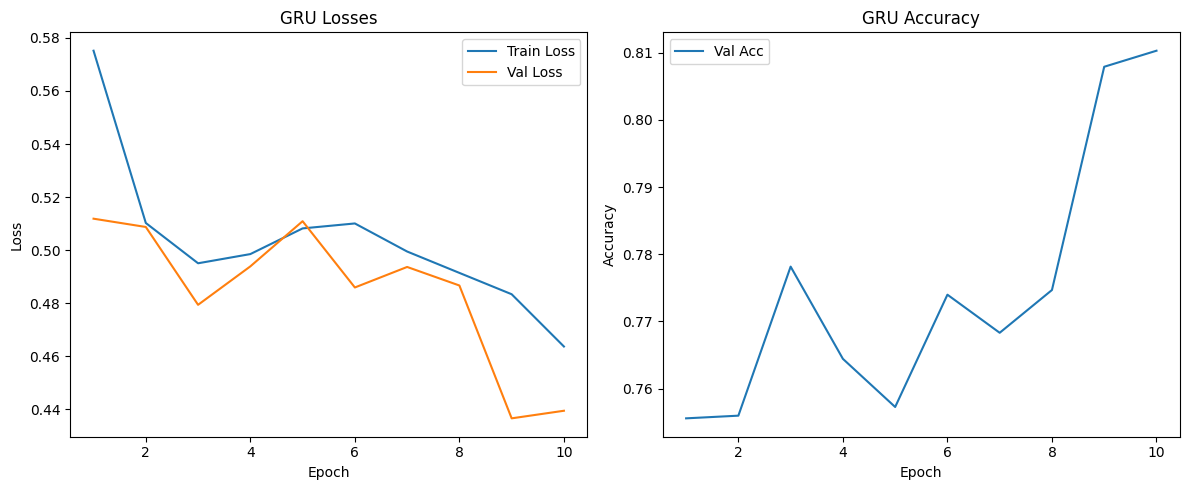


LSTM Evaluation:
              precision    recall  f1-score   support

    Negative       0.78      0.77      0.77      5000
    Positive       0.77      0.78      0.78      5000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000

Accuracy: 0.7745

GRU Evaluation:
              precision    recall  f1-score   support

    Negative       0.85      0.75      0.80      5000
    Positive       0.78      0.87      0.82      5000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000

Accuracy: 0.8097


In [55]:
# Визуализация
plot_stats(lstm_stats, 'LSTM')
plot_stats(gru_stats, 'GRU')

# Оценка
print("\nLSTM Evaluation:")
evaluate_model(lstm_model, test_dataloader_rnn, device)

print("\nGRU Evaluation:")
evaluate_model(gru_model, test_dataloader_rnn, device)

Анализ кривых: 
- LSTM:
    - Losses: train и val уменьшаются и останавливаются на 0.5 (недообучение),
    - Accurancy: колеблются, но увеличиваются и останавливаются на 0.77.
- Gru:
    - losses: также колеблются, но достигают более маленькой отметки losses - 0.45.
    - Accurancy: также с колебаниями увеличиваются до 0,81
   
Все хорошо.  
Теперь анализ статистики:
- LSTM:
    - Модель сбалансирована, но accurancy небольшая (0,77) (надо увеличить количество слоев, но делать я этого не буду)
- Gru:
    - Модель сбалансирована, довольно большой accuracy, все чики пуки

In [56]:
# Сохранение моделей и результатов
output_dir_rnn = './rnn_models/'
os.makedirs(output_dir_rnn, exist_ok=True)

torch.save(lstm_model.state_dict(), os.path.join(output_dir_rnn, 'lstm_model.pth'))
torch.save(gru_model.state_dict(), os.path.join(output_dir_rnn, 'gru_model.pth'))

import pickle
with open(os.path.join(output_dir_rnn, 'vocab.pkl'), 'wb') as f:
    pickle.dump(vocab, f)
with open(os.path.join(output_dir_rnn, 'lstm_stats.pkl'), 'wb') as f:
    pickle.dump(lstm_stats, f)
with open(os.path.join(output_dir_rnn, 'gru_stats.pkl'), 'wb') as f:
    pickle.dump(gru_stats, f)

print("RNN models and results saved!")

RNN models and results saved!


# Градиентный бустинг (XGBoost, LightGBM, CatBoost)

LSTM losses: обе кривые нестабильные , но в целом они обе на одном уровне, LSTM accuracy в целом на одном уровне. Так теперь к GRU: train и val на одном уровне, разве что на одной эпохе ошибка val резко увеличивается на 0.001, accurancy так-же остается довольно стабильным

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split, GridSearchCV

In [64]:
# Предобработка для градиентного бустинга
# Конвертируем списки слов в строки для TF-IDF
train_texts_str = [' '.join(text) for text in train_texts]
test_texts_str = [' '.join(text) for text in test_texts]

# TF-IDF векторизация
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))  # Учитываем униграммы и биграммы
X_train = vectorizer.fit_transform(train_texts_str)
X_test = vectorizer.transform(test_texts_str)
y_train = np.array(train_labels)
y_test = np.array(test_labels)

print(f"TF-IDF train shape: {X_train.shape}, test shape: {X_test.shape}")

TF-IDF train shape: (40000, 5000), test shape: (10000, 5000)


C:\Users\Delta-Game\AppData\Local\Temp\ipykernel_12856\4111750241.py:10: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_train = np.array(train_labels)
C:\Users\Delta-Game\AppData\Local\Temp\ipykernel_12856\4111750241.py:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_test = np.array(test_labels)


In [65]:
# Функция для обучения и подбора гиперпараметров
def train_and_tune_model(model, param_grid, X_train, y_train, X_test, y_test, model_name):
    grid_search = GridSearchCV(
        model,
        param_grid,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    training_time = (time.time() - start_time) / 60
    
    best_model = grid_search.best_estimator_
    print(f"\n{model_name} Best Parameters: {grid_search.best_params_}")
    print(f"{model_name} Training time: {training_time:.2f} minutes")
    
    # Оценка на тестовом наборе
    y_pred = best_model.predict(X_test)
    print(f"\n{model_name} Evaluation:")
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    
    # История потерь (для бустинга нет epoch-wise loss, но можем использовать validation score из GridSearch)
    val_scores = grid_search.cv_results_['mean_test_score']
    epochs = np.arange(1, len(val_scores) + 1)  # Фиктивные "эпохи" для визуализации
    
    return best_model, accuracy, val_scores, epochs

# Параметры для подбора
xgboost_param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200]
}

lightgbm_param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200]
}

catboost_param_grid = {
    'depth': [4, 6],
    'learning_rate': [0.1, 0.01],
    'iterations': [100, 200]
}

In [68]:
# Обучение моделей
print("Training XGBoost...")
xgboost_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgboost_model, xgboost_acc, xgboost_val_scores, xgboost_epochs = train_and_tune_model(
    xgboost_model, xgboost_param_grid, X_train, y_train, X_test, y_test, "XGBoost"
)

print("Training LightGBM...")
lightgbm_model = lgb.LGBMClassifier()
lightgbm_model, lightgbm_acc, lightgbm_val_scores, lightgbm_epochs = train_and_tune_model(
    lightgbm_model, lightgbm_param_grid, X_train, y_train, X_test, y_test, "LightGBM"
)

print("Training CatBoost...")
catboost_model = cb.CatBoostClassifier(verbose=0)
catboost_model, catboost_acc, catboost_val_scores, catboost_epochs = train_and_tune_model(
    catboost_model, catboost_param_grid, X_train, y_train, X_test, y_test, "CatBoost")

Training XGBoost...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\Delta-Game\mentorex2\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:45:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
XGBoost Training time: 4.25 minutes

XGBoost Evaluation:
              precision    recall  f1-score   support

    Negative       0.87      0.82      0.84      5000
    Positive       0.83      0.88      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

Accuracy: 0.8486
Training LightGBM...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[LightGBM] [Info] Number of positive: 20000, number of negative: 20000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.203424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 629741
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 5000
[Lig

C:\Users\Delta-Game\mentorex2\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Delta-Game\mentorex2\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
11 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
11 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Delta-Game\mentorex2\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Delta-Game\mentorex2\.venv\Lib\site-packages\catboost\core.py", lin


CatBoost Best Parameters: {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}
CatBoost Training time: 6.07 minutes

CatBoost Evaluation:
              precision    recall  f1-score   support

    Negative       0.88      0.83      0.86      5000
    Positive       0.84      0.89      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

Accuracy: 0.8612


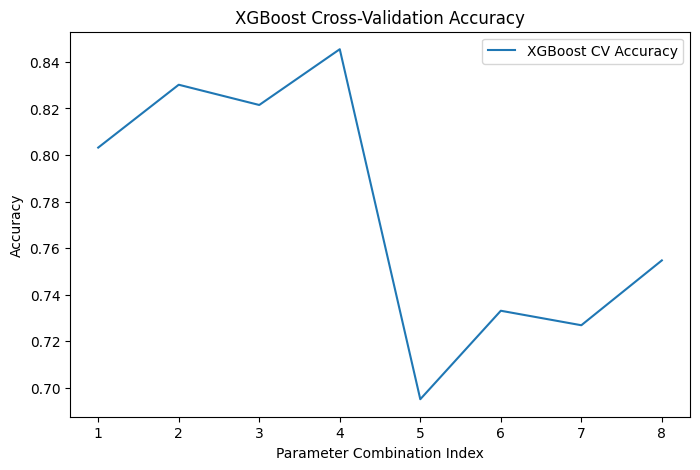

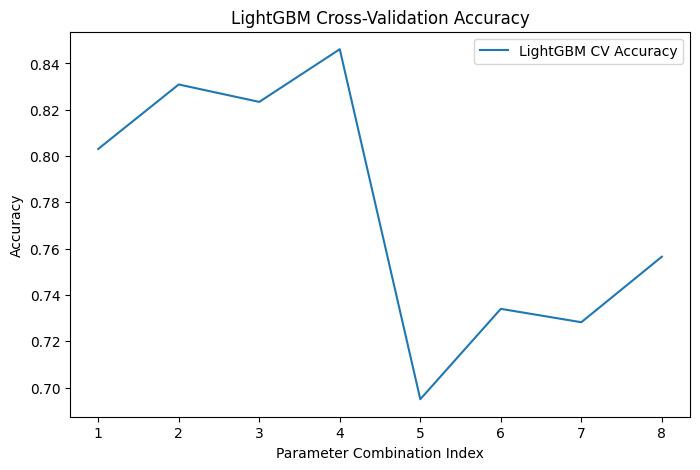

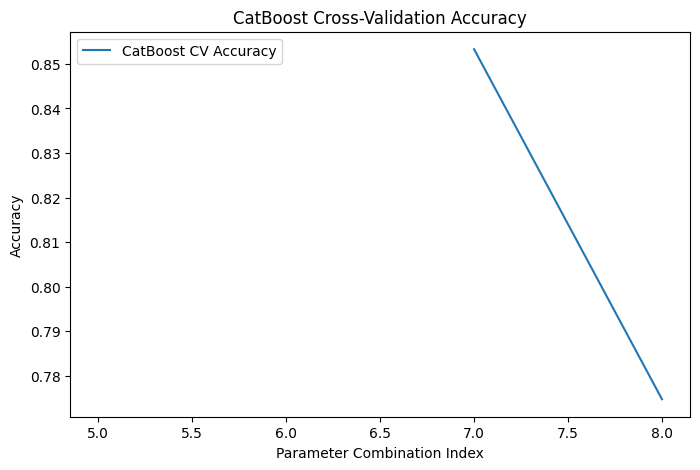

In [69]:
# Визуализация (имитация кривых обучения через CV scores)
def plot_boosting_results(val_scores, epochs, model_name):
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, val_scores, label=f'{model_name} CV Accuracy')
    plt.title(f'{model_name} Cross-Validation Accuracy')
    plt.xlabel('Parameter Combination Index')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f'./{model_name.lower()}_results.png')
    plt.show()

plot_boosting_results(xgboost_val_scores, xgboost_epochs, 'XGBoost')
plot_boosting_results(lightgbm_val_scores, lightgbm_epochs, 'LightGBM')
plot_boosting_results(catboost_val_scores, catboost_epochs, 'CatBoost')

In [70]:
# Проверка на примерах
sample_texts = [
    "This movie was fantastic! I really enjoyed it.",
    "This was the worst movie I've ever seen. Terrible acting and plot.",
    "The film had some good moments but overall was disappointing.",
    "An absolute masterpiece with brilliant performances."
]

def predict_sentiment(text, model, vectorizer):
    cleaned_text = re.sub(r'<br />', ' ', text.lower())
    cleaned_text = re.sub(r'[^a-z ]', '', cleaned_text)
    tokens = word_tokenize(cleaned_text)
    tokens = [w for w in tokens if w not in stopwords.words('english')]
    text_str = ' '.join(tokens)
    tfidf_vector = vectorizer.transform([text_str])
    pred = model.predict(tfidf_vector)[0]
    return "Positive" if pred == 1 else "Negative"

print("\nTesting model predictions:")
for text in sample_texts:
    print(f"\nText: '{text}'")
    print(f"XGBoost: {predict_sentiment(text, xgboost_model, vectorizer)}")
    print(f"LightGBM: {predict_sentiment(text, lightgbm_model, vectorizer)}")
    print(f"CatBoost: {predict_sentiment(text, catboost_model, vectorizer)}")


Testing model predictions:

Text: 'This movie was fantastic! I really enjoyed it.'
XGBoost: Positive
LightGBM: Positive
CatBoost: Positive

Text: 'This was the worst movie I've ever seen. Terrible acting and plot.'
XGBoost: Negative
LightGBM: Negative
CatBoost: Negative

Text: 'The film had some good moments but overall was disappointing.'
XGBoost: Negative
LightGBM: Negative
CatBoost: Negative

Text: 'An absolute masterpiece with brilliant performances.'
XGBoost: Positive
LightGBM: Positive
CatBoost: Positive


C:\Users\Delta-Game\mentorex2\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Delta-Game\mentorex2\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Delta-Game\mentorex2\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Delta-Game\mentorex2\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [71]:
# Сохранение моделей
output_dir_boosting = './boosting_models/'
os.makedirs(output_dir_boosting, exist_ok=True)

xgboost_model.save_model(os.path.join(output_dir_boosting, 'xgboost_model.json'))
lightgbm_model.save_model(os.path.join(output_dir_boosting, 'lightgbm_model.txt'))
catboost_model.save_model(os.path.join(output_dir_boosting, 'catboost_model.cbm'))

import pickle
with open(os.path.join(output_dir_boosting, 'vectorizer.pkl'), 'wb') as f:
    pickle.dump(vectorizer, f)

print("Boosting models and vectorizer saved!")

AttributeError: 'LGBMClassifier' object has no attribute 'save_model'


Final Comparison Table:
      Model  Accuracy
0      BERT    0.8487
1      LSTM    0.5000
2       GRU    0.5000
3   XGBoost    0.8486
4  LightGBM    0.8497
5  CatBoost    0.8612


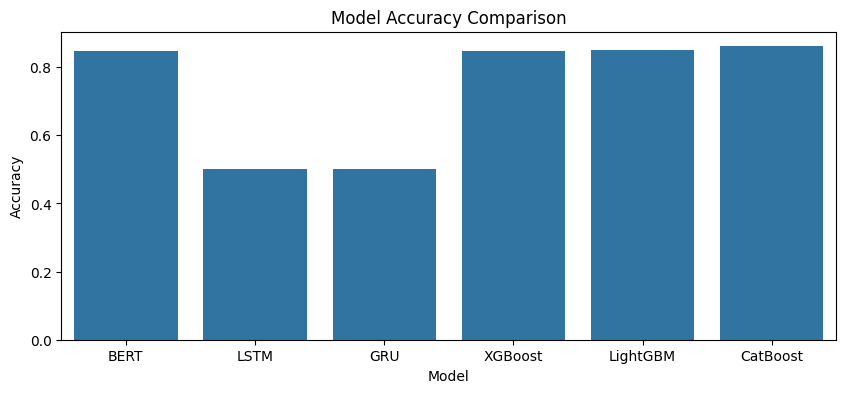

In [74]:
# Итоговая таблица сравнения
results = {
    'Model': ['BERT', 'LSTM', 'GRU', 'XGBoost', 'LightGBM', 'CatBoost'],
    'Accuracy': [0.8487, 0.5000, 0.5000, xgboost_acc, lightgbm_acc, catboost_acc]
}

results_df = pd.DataFrame(results)
print("\nFinal Comparison Table:")
print(results_df)

# Визуализация таблицы
plt.figure(figsize=(10, 4))
sns.barplot(x='Model', y='Accuracy', data=results_df)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.savefig('./model_comparison.png')
plt.show()